In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from hydra.utils import instantiate
from hydra import initialize, compose
import hydra

import wandb

from data.dataManager import DataManager
from model.modelCreator import ModelCreator
from omegaconf import OmegaConf
from scripts.run import setup_model, load_model_instance

from utils.plots import vae_plots
from utils.rbm_plots import plot_rbm_histogram

[23:33:15.620] INFO   CaloQuVAE                                         Loading configuration.
[23:33:15.625] INFO   CaloQVAE                                          Willkommen!
[23:33:15.626] INFO   CaloQVAE                                          Loading configuration.


In [2]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="config")
config=compose(config_name="config.yaml")
wandb.init(tags = [config.data.dataset_name], project=config.wandb.project, entity=config.wandb.entity, config=OmegaConf.to_container(config, resolve=True), mode='disabled')

In [3]:
new_model = True
if new_model:
    self = setup_model(config)
    # self.model = self.model.double()  # sets all model parameters to float64
else:
    self = load_model_instance(config.config_path)
    # self.model = self.model.double()


[23:33:20.797] INFO   data.dataManager                                  Loading ATLAS dataset: AtlasReg025
[23:33:22.923] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fb1cd6e9370>: 101815 events, 199 batches
[23:33:22.926] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fb126423f20>: 12728 events, 13 batches
[23:33:22.927] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fb126cfb4a0>: 12726 events, 13 batches
[23:33:22.928] INFO   model.modelCreator                                ::Creating Model
[23:33:24.333] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers
[23:33:24.388] INFO   dwave.cloud.client.base                           Received solver data for 7 solver(s).
[23:33:24.614] INFO   dwave.cloud.client.base                           Adding sol

cuda:1
encoder._networks.0.seq1.0.conv.weight True
encoder._networks.0.seq1.0.conv.bias True
encoder._networks.0.seq1.1.weight True
encoder._networks.0.seq1.1.bias True
encoder._networks.0.seq1.2.weight True
encoder._networks.0.seq1.3.conv.weight True
encoder._networks.0.seq1.3.conv.bias True
encoder._networks.0.seq1.4.weight True
encoder._networks.0.seq1.4.bias True
encoder._networks.0.seq1.5.weight True
encoder._networks.0.seq2.0.conv.weight True
encoder._networks.0.seq2.0.conv.bias True
encoder._networks.0.seq2.1.weight True
encoder._networks.0.seq2.1.bias True
encoder._networks.0.seq2.2.weight True
encoder._networks.0.seq2.3.conv.weight True
encoder._networks.0.seq2.3.conv.bias True
encoder._networks.0.seq2.4.weight True
encoder._networks.1.seq1.0.conv.weight True
encoder._networks.1.seq1.0.conv.bias True
encoder._networks.1.seq1.1.weight True
encoder._networks.1.seq1.1.bias True
encoder._networks.1.seq1.2.weight True
encoder._networks.1.seq1.3.conv.weight True
encoder._networks.1.

[23:33:37.949] INFO   engine.engine                                     Epoch: 0 [0/13 (0%)]	 Batch Loss: 27500.4629


Max value: 5821889.5, Min value: 0.018318314105272293
Max value: 1.7824485301971436, Min value: 9.809677430894226e-05
Max value: 0.9965986609458923, Min value: 0.23681972920894623
Max value: 584.1570434570312, Min value: 0.018318314105272293
Max value: 1.7824485301971436, Min value: 9.809677430894226e-05
Max value: 0.9965986609458923, Min value: 0.32185372710227966
Max value: 1029.0740966796875, Min value: 0.03628340736031532
Max value: 1.534829020500183, Min value: 9.996024891734123e-05
Max value: 0.9889456033706665, Min value: 0.32482993602752686
Max value: 1650.7281494140625, Min value: 0.07471981644630432
Max value: 1.2385565042495728, Min value: 0.00010092626325786114
Max value: 0.9685373902320862, Min value: 0.31887754797935486
Max value: 3174.39697265625, Min value: 0.14981615543365479
Max value: 1.1897742748260498, Min value: 0.00010063903027912602
Max value: 0.928146243095398, Min value: 0.3235544264316559
Max value: 5957.4296875, Min value: 0.3011062443256378
Max value: 1.108

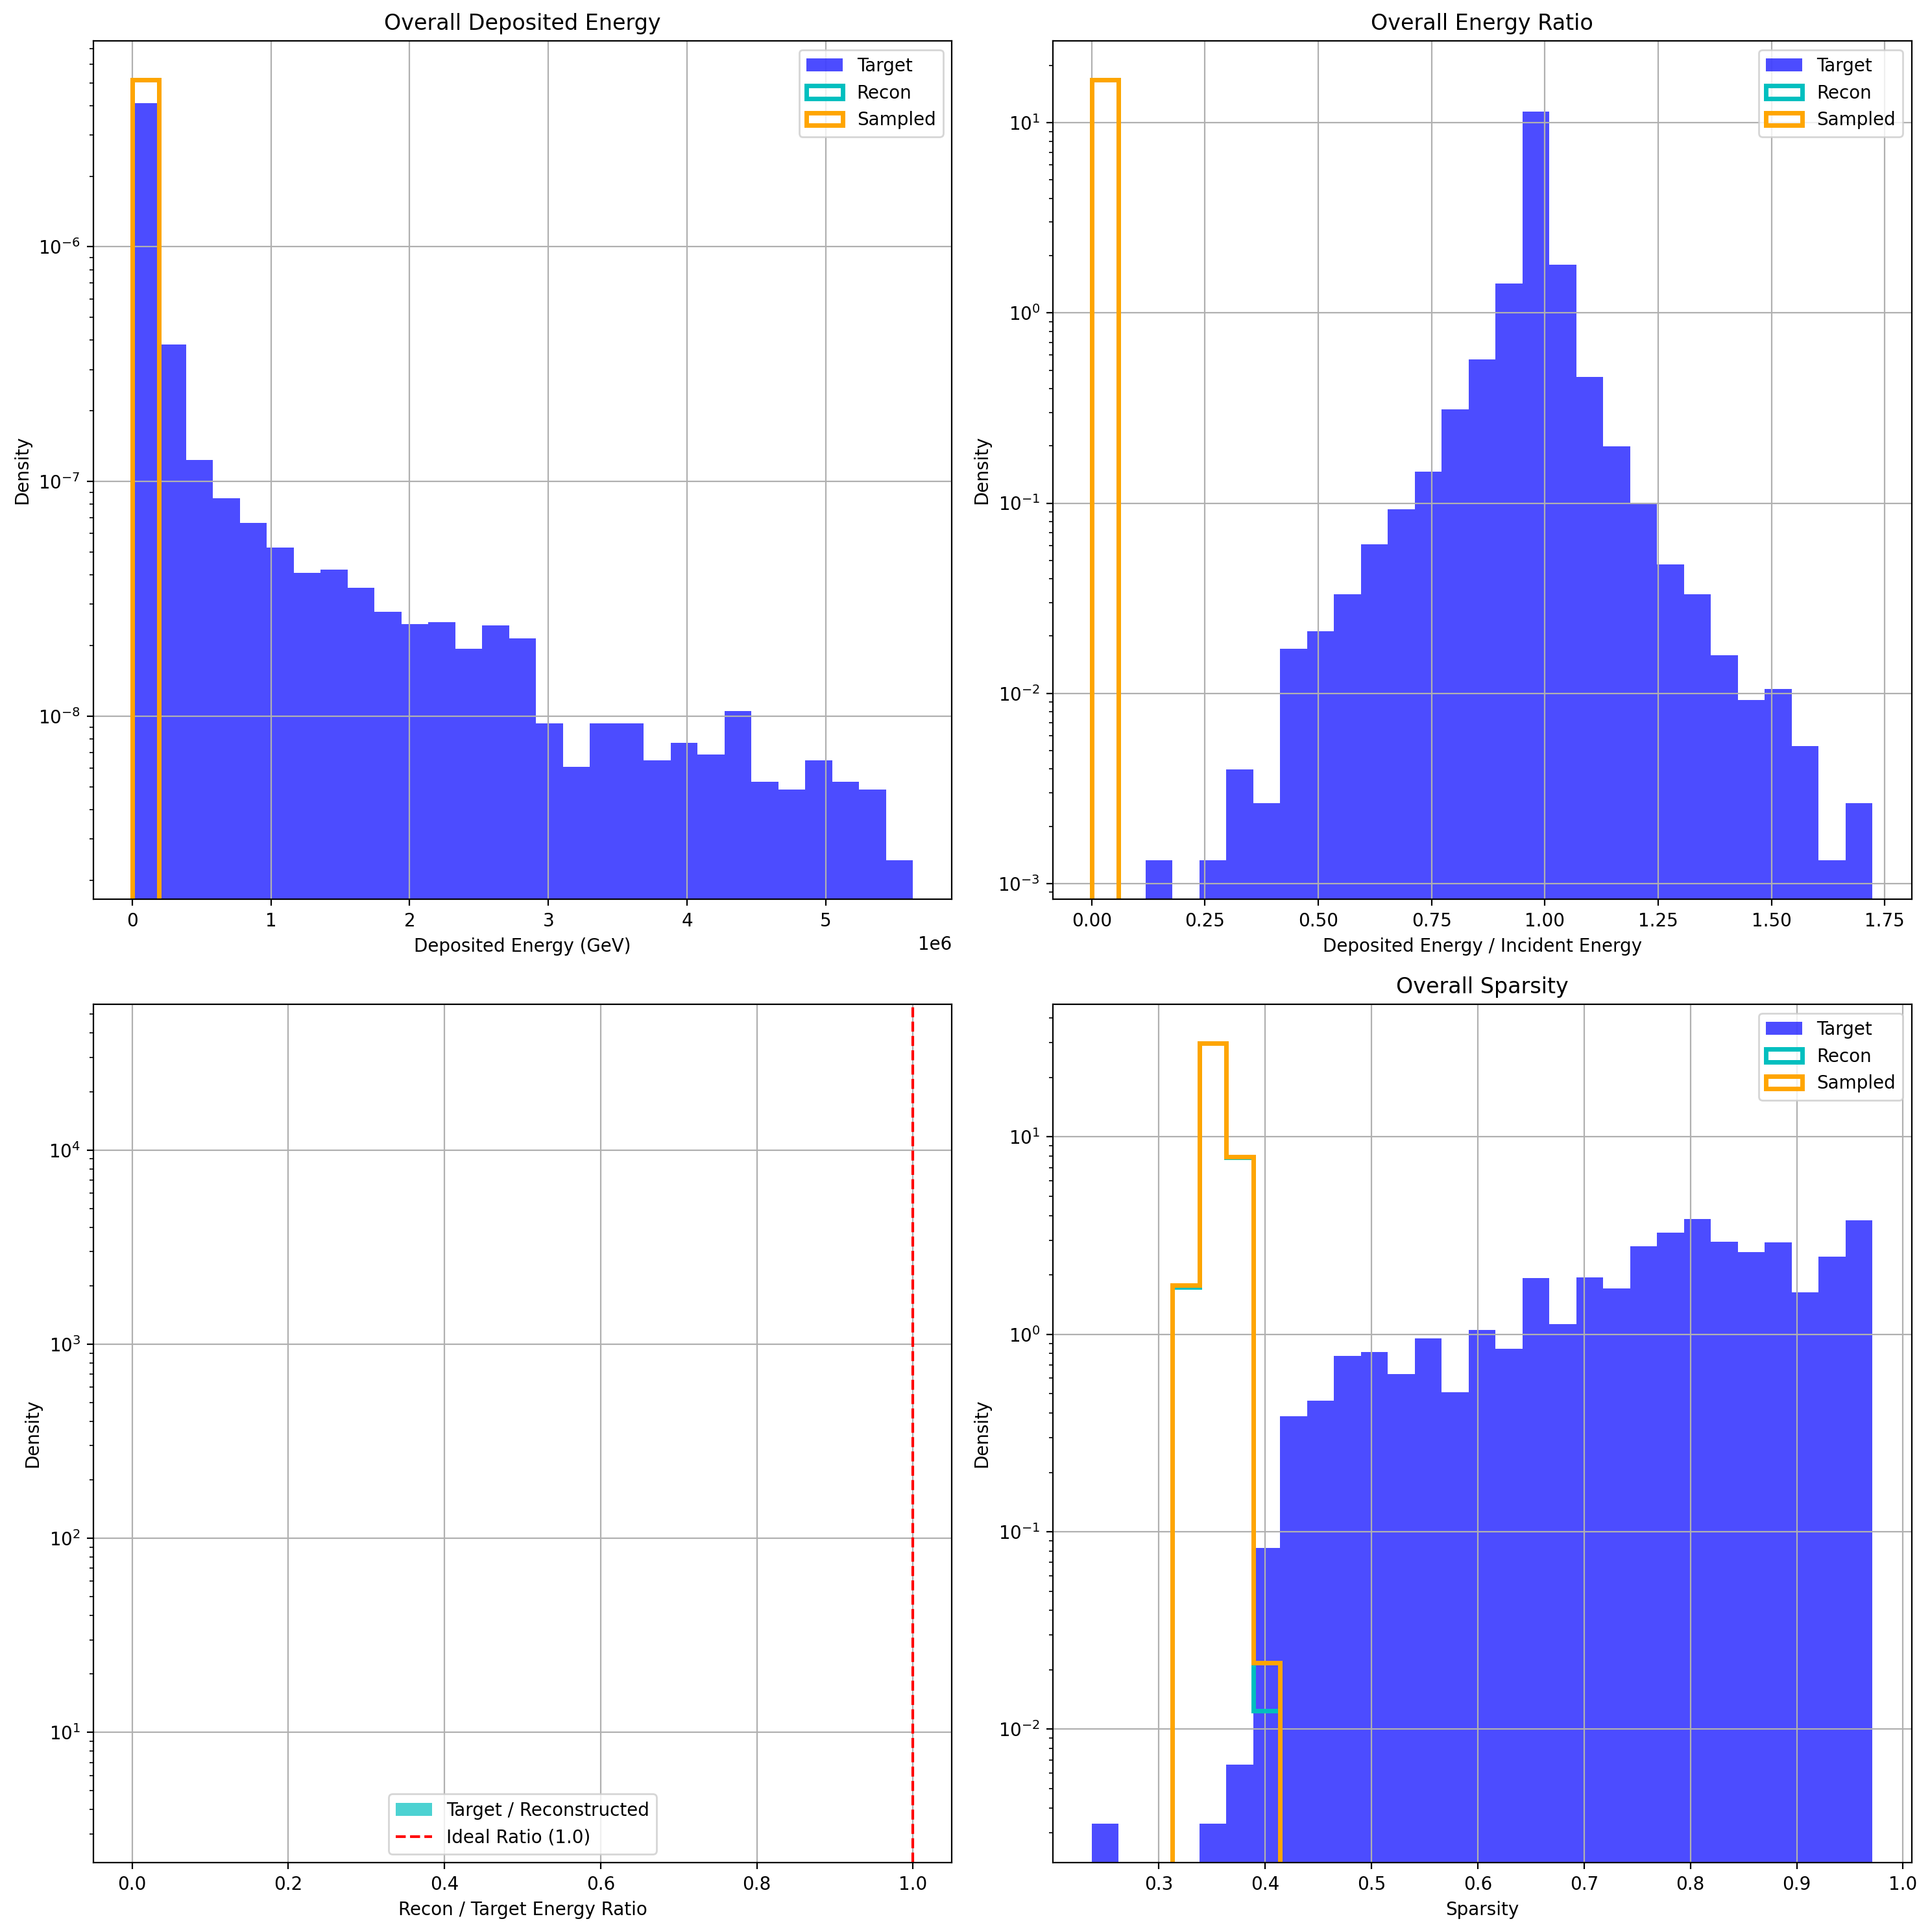

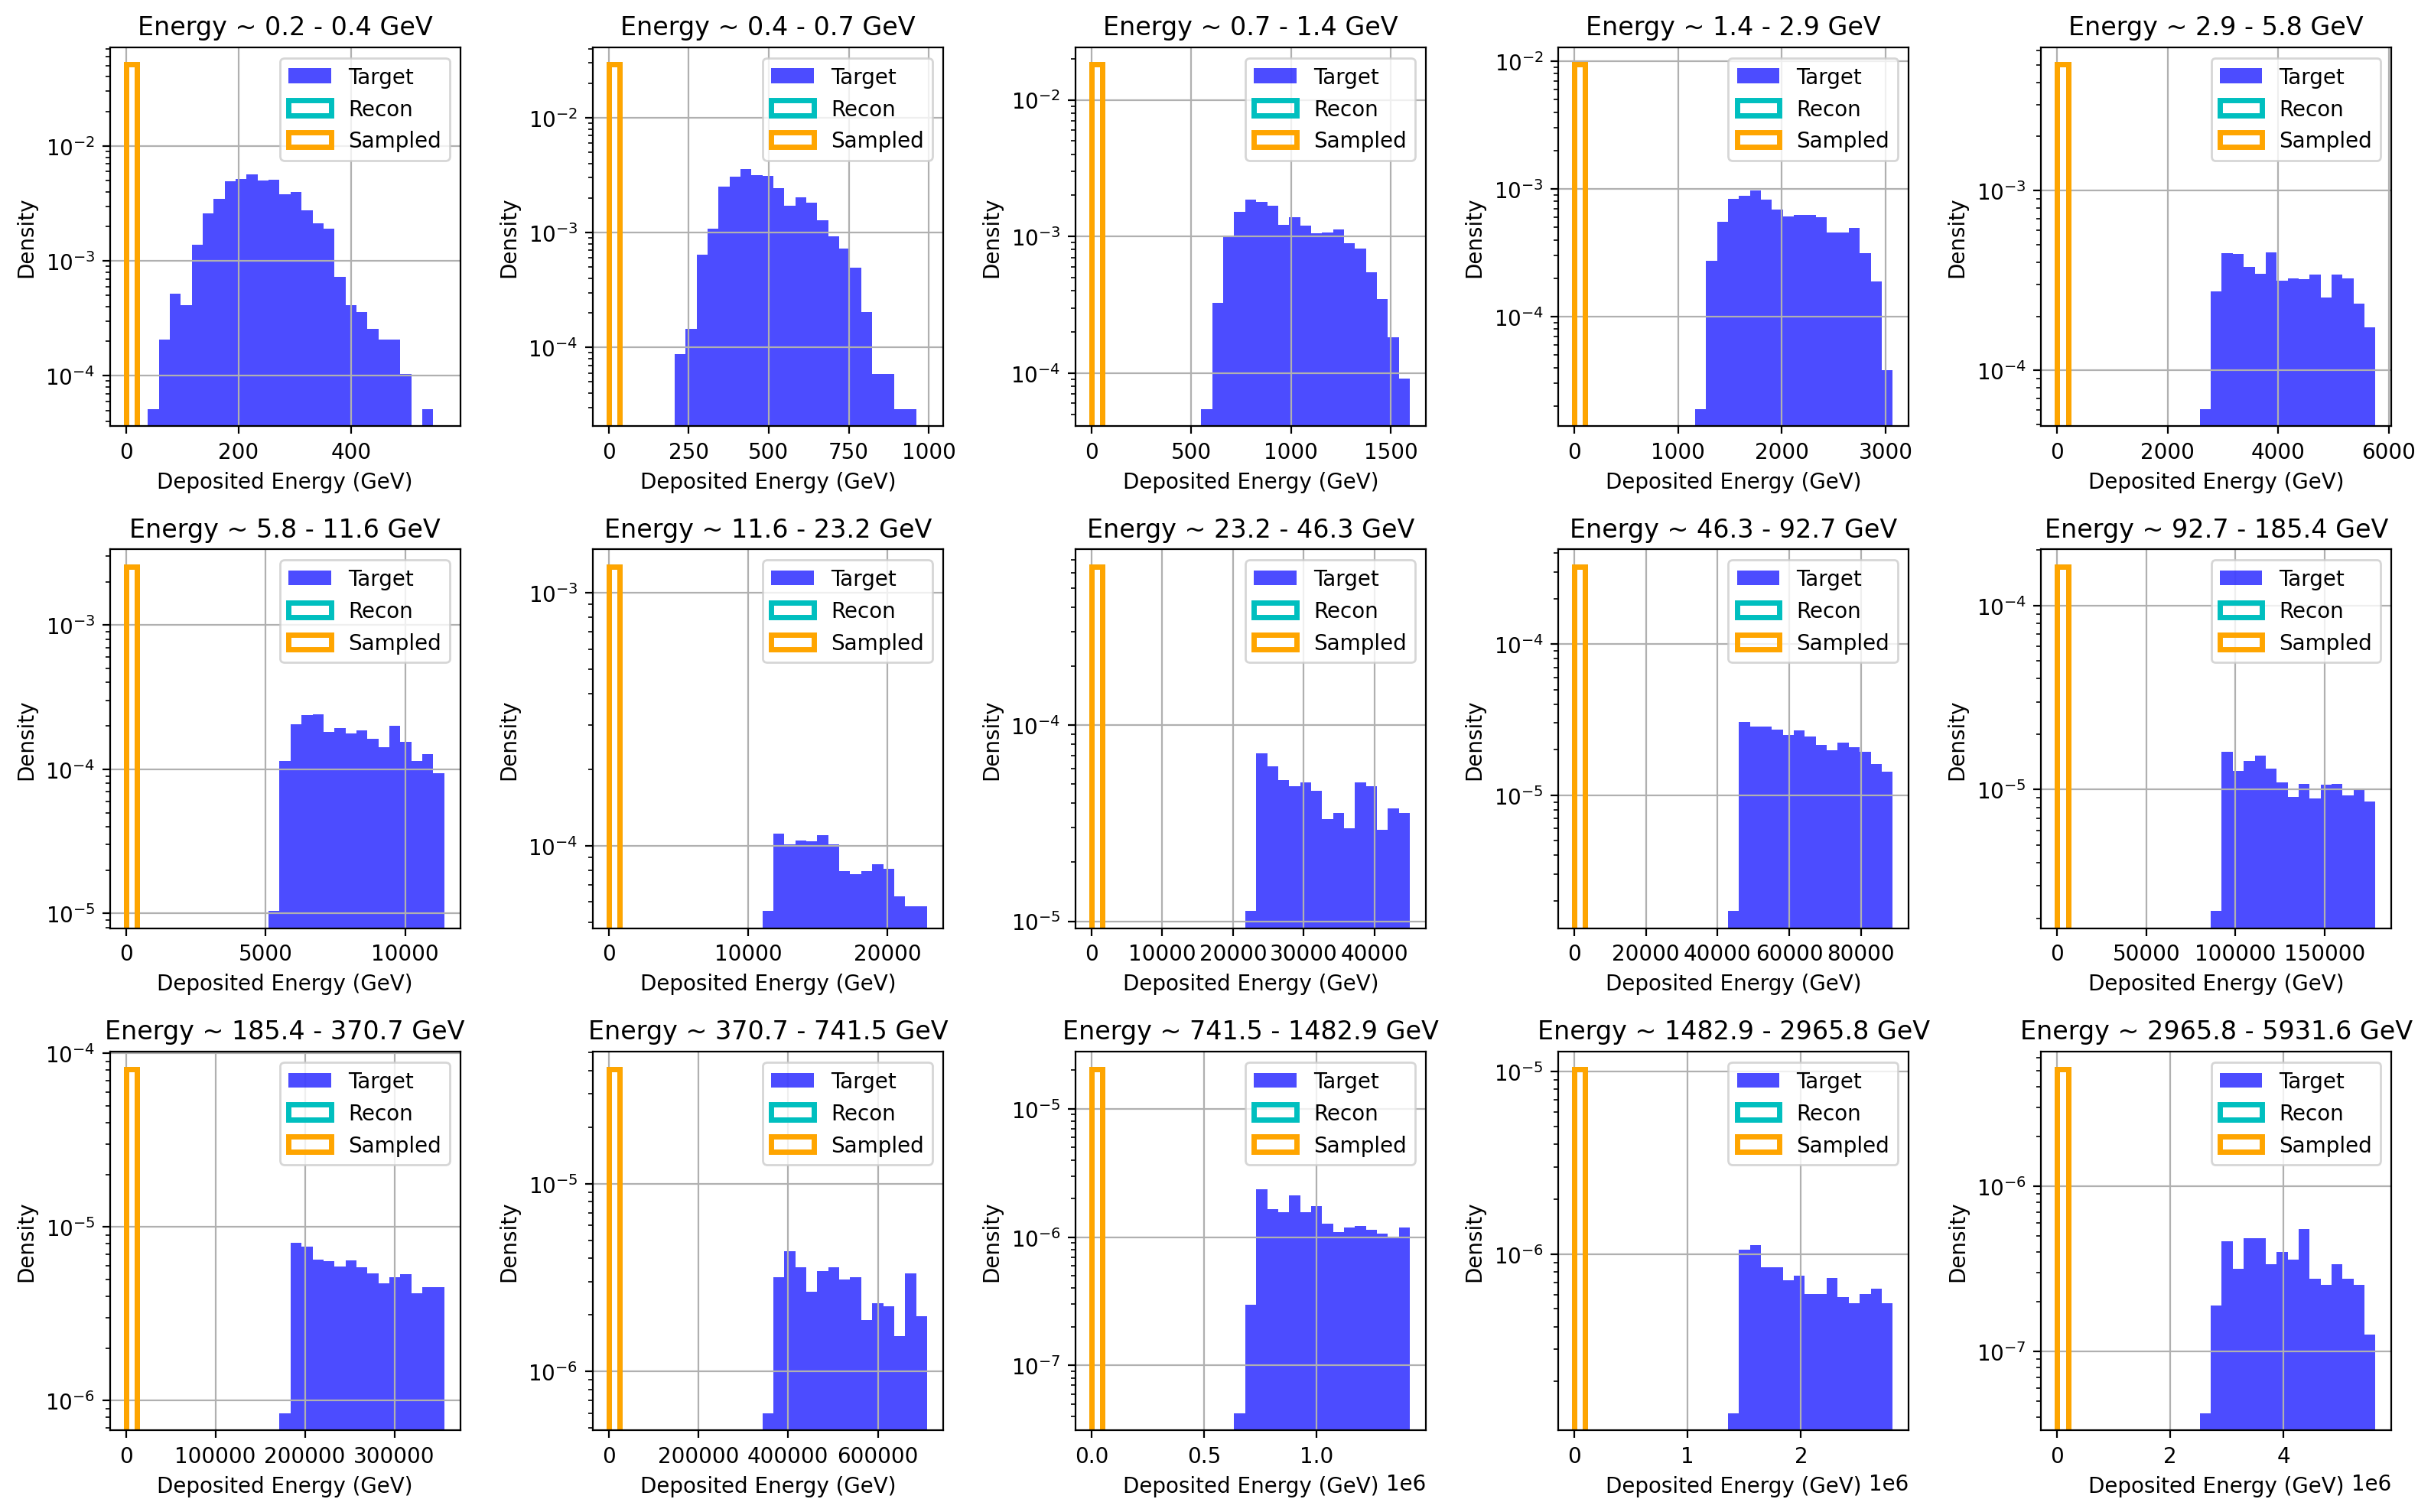

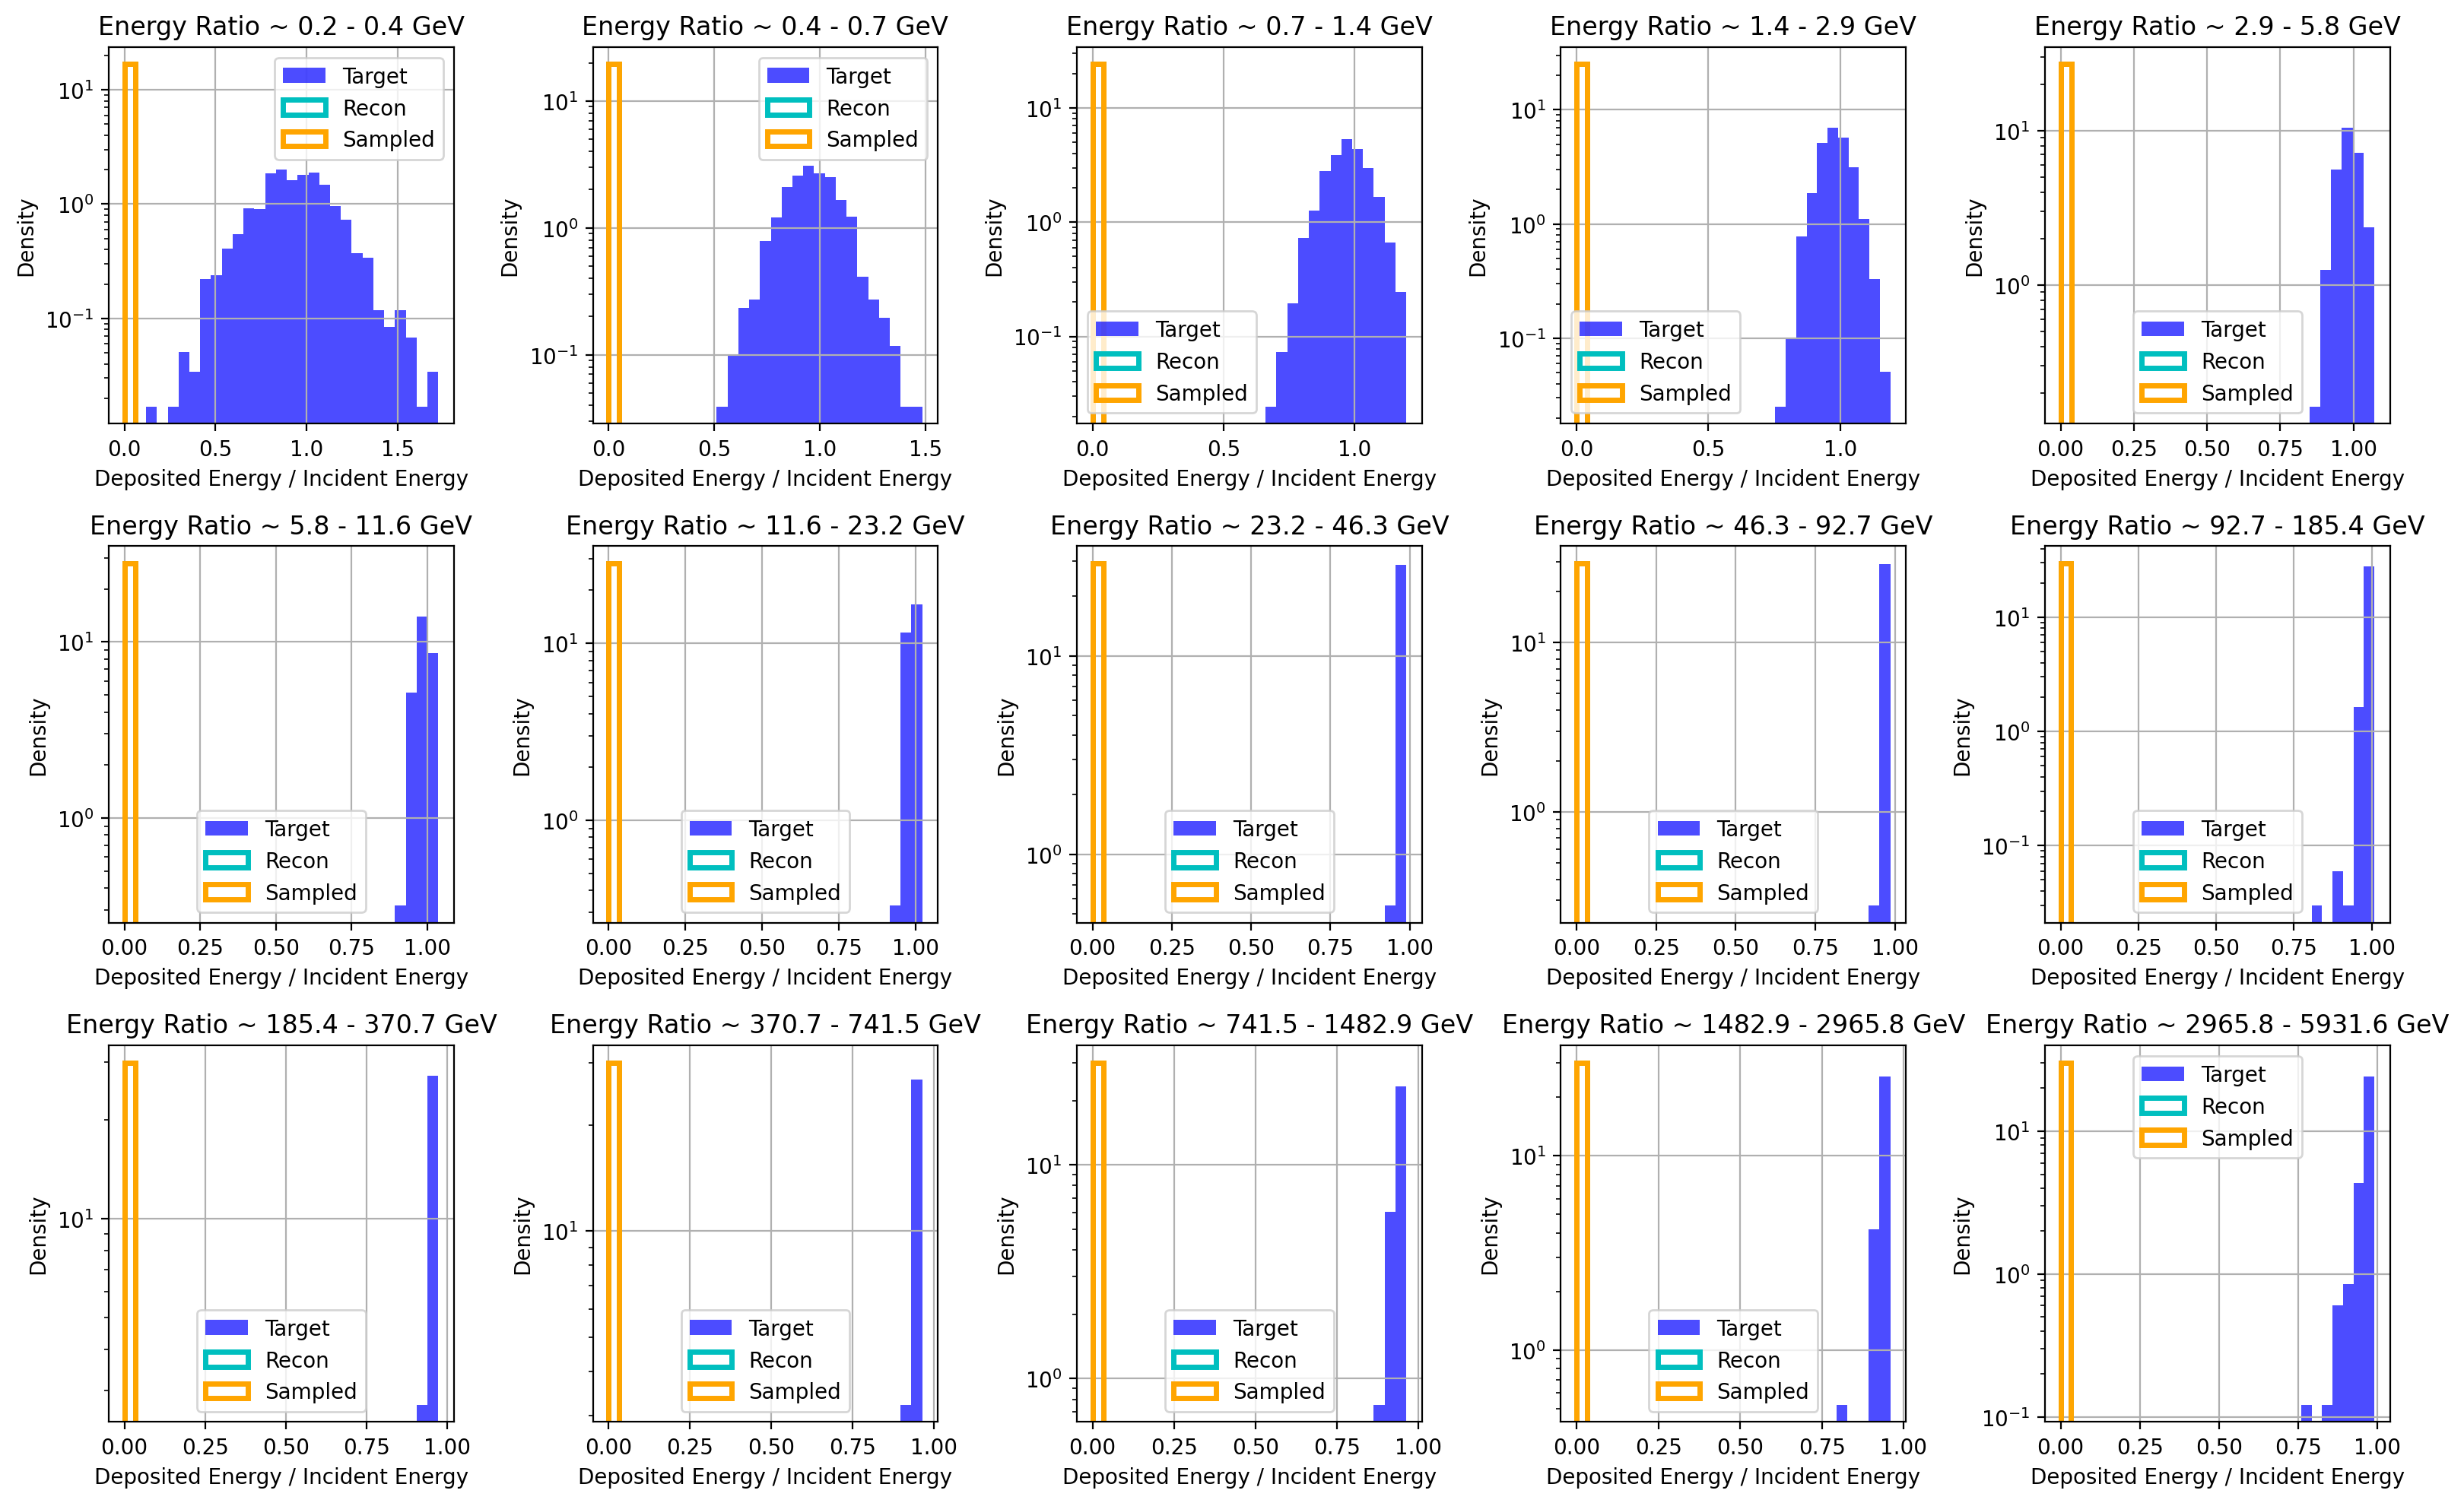

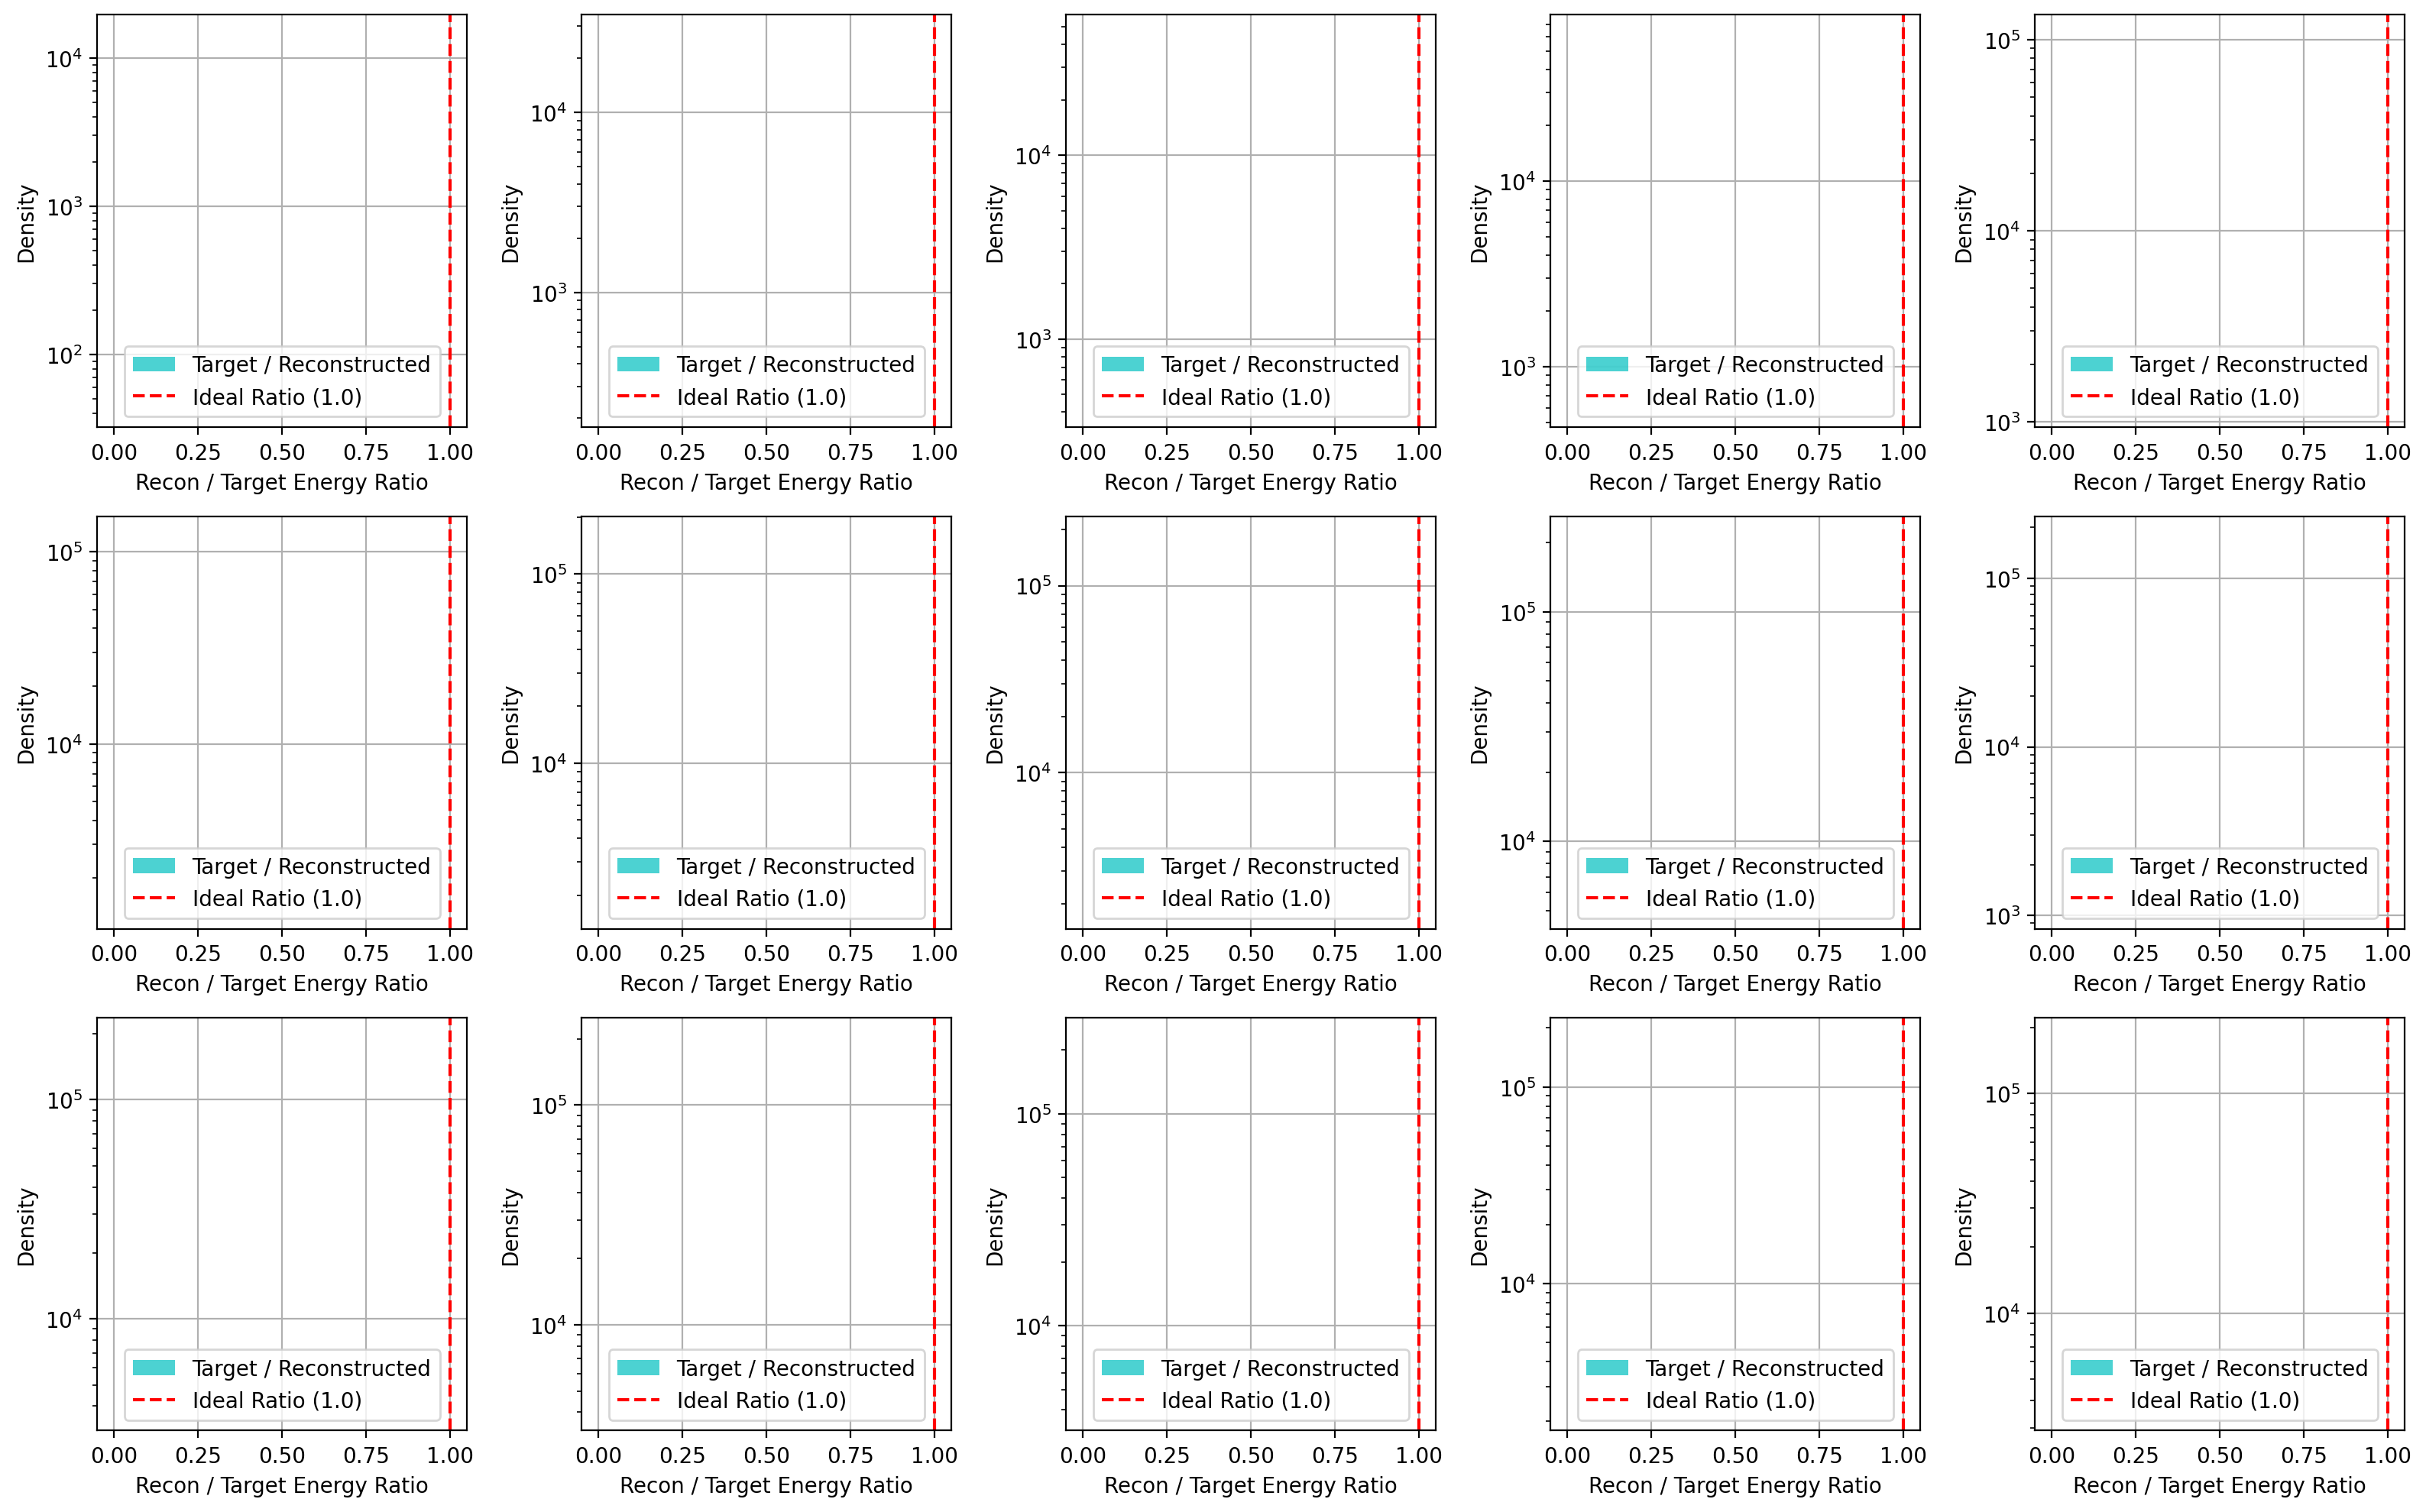

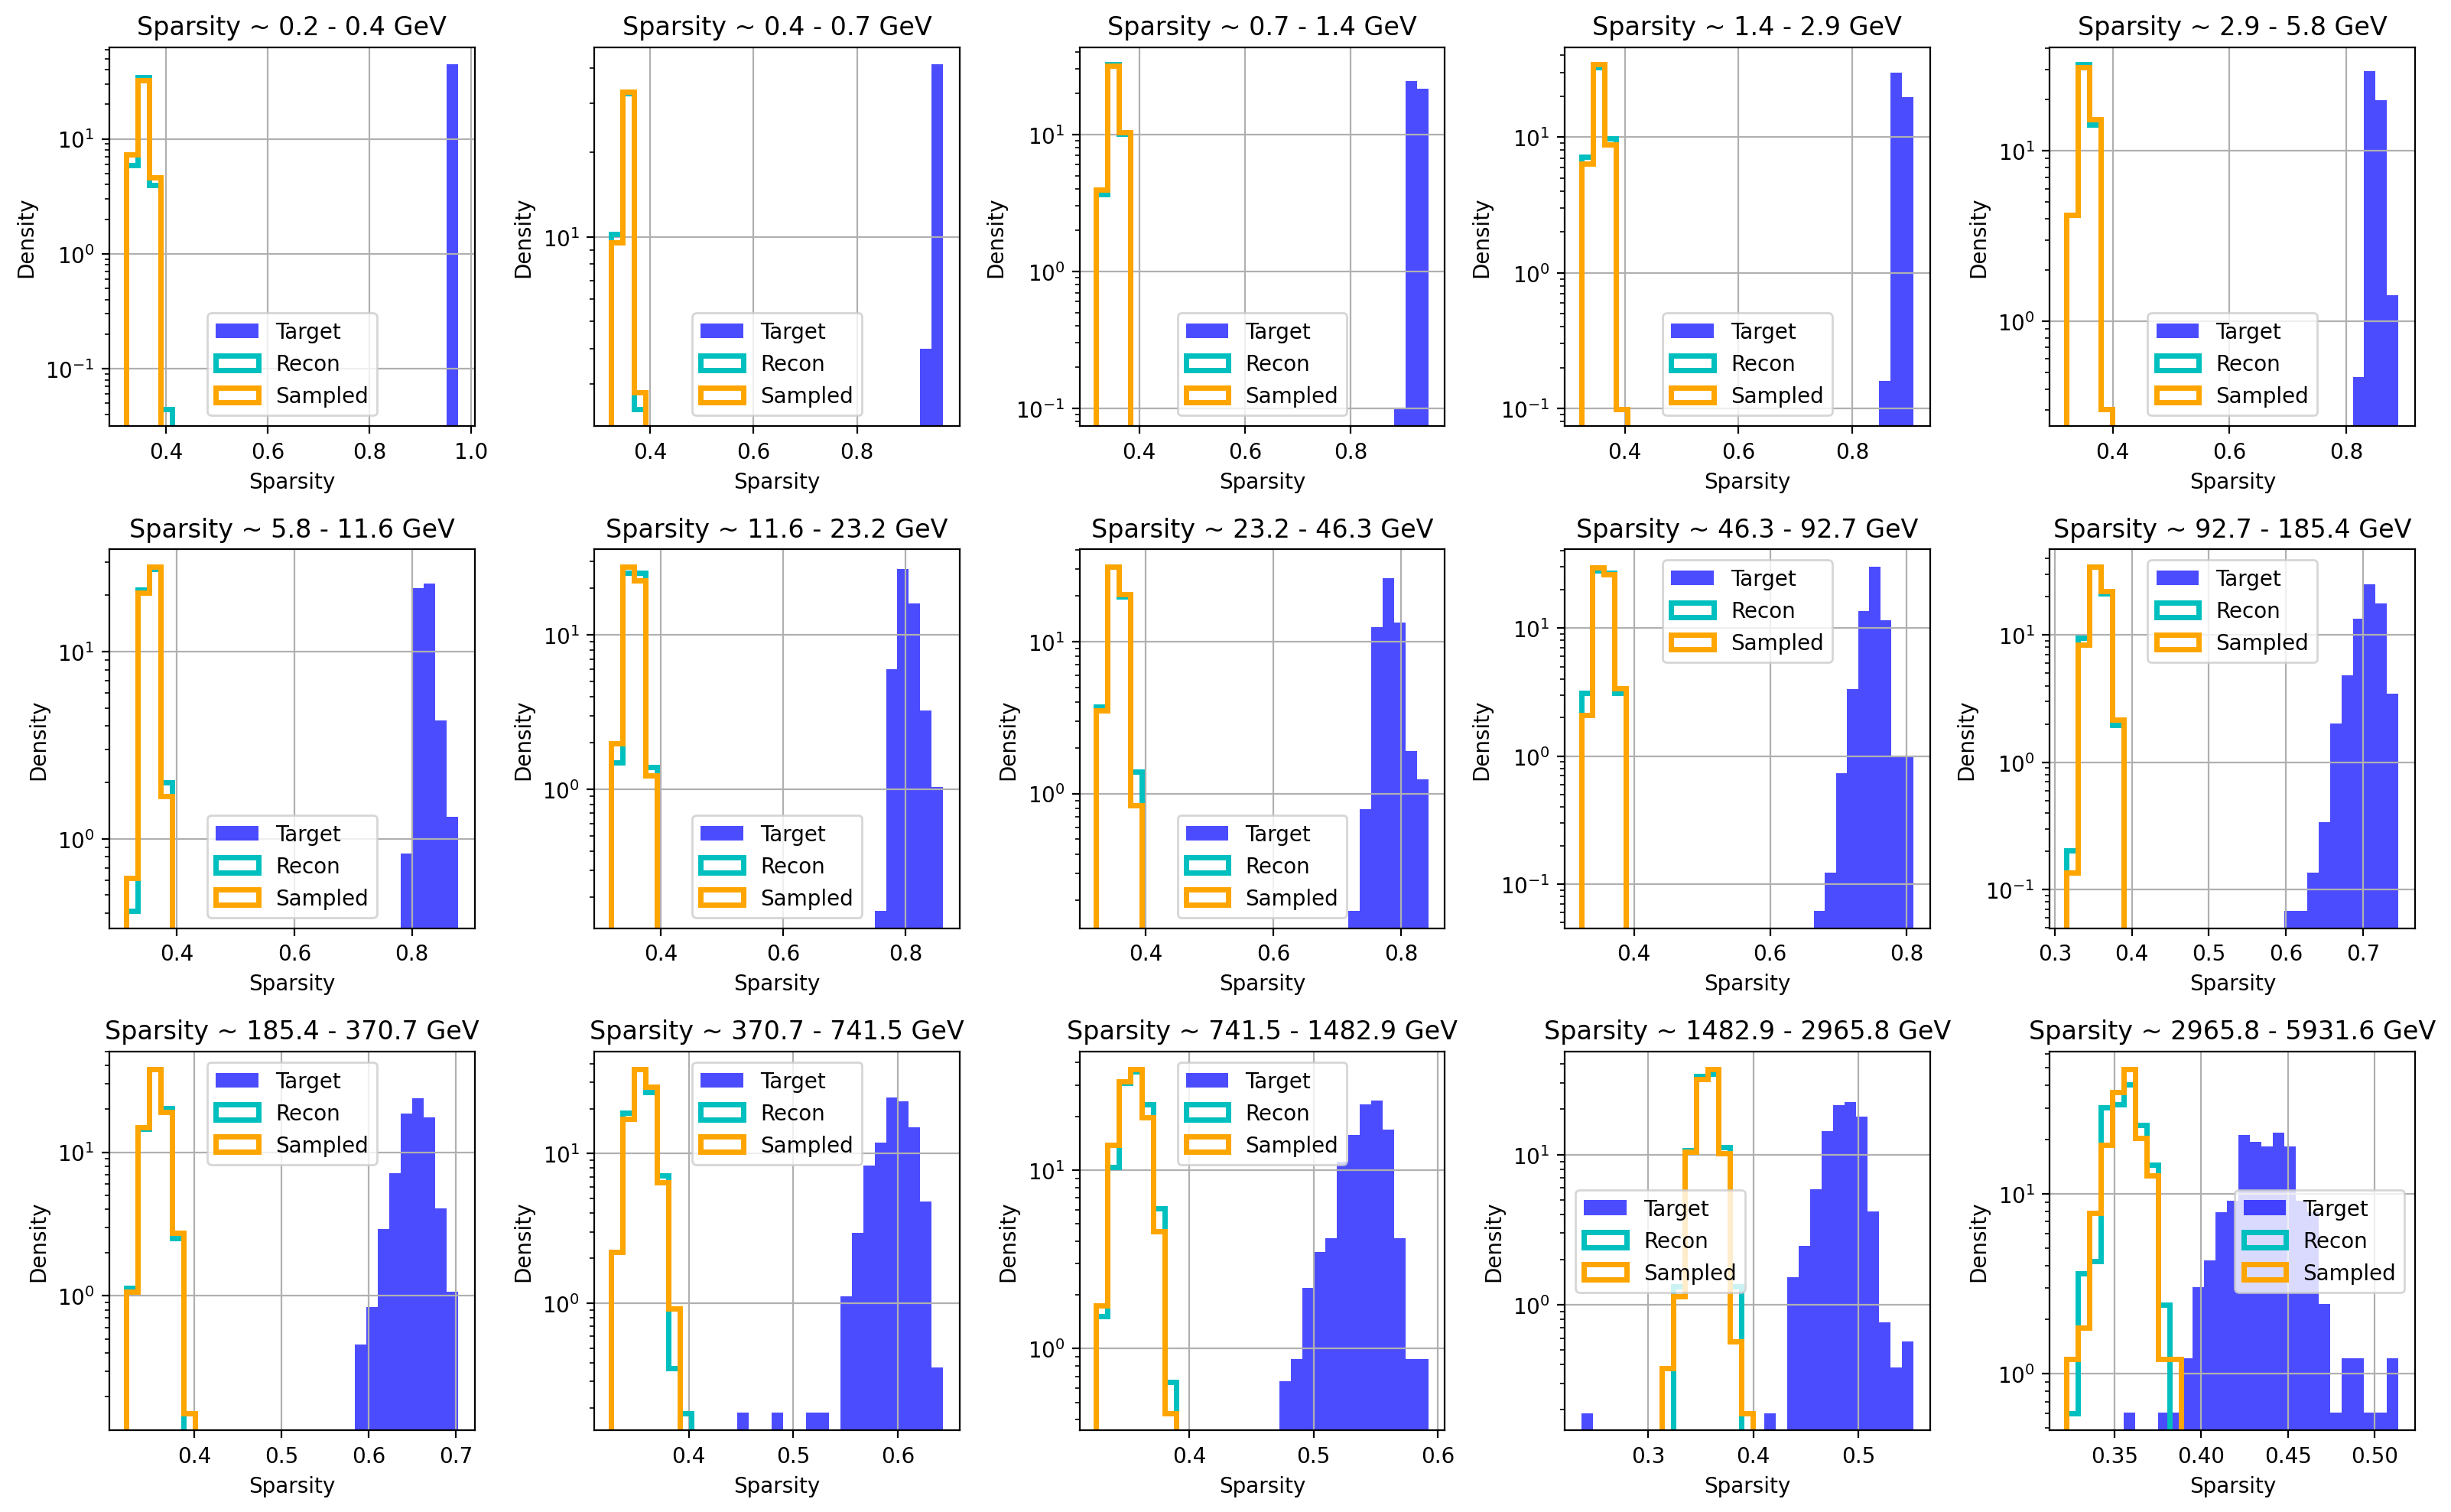

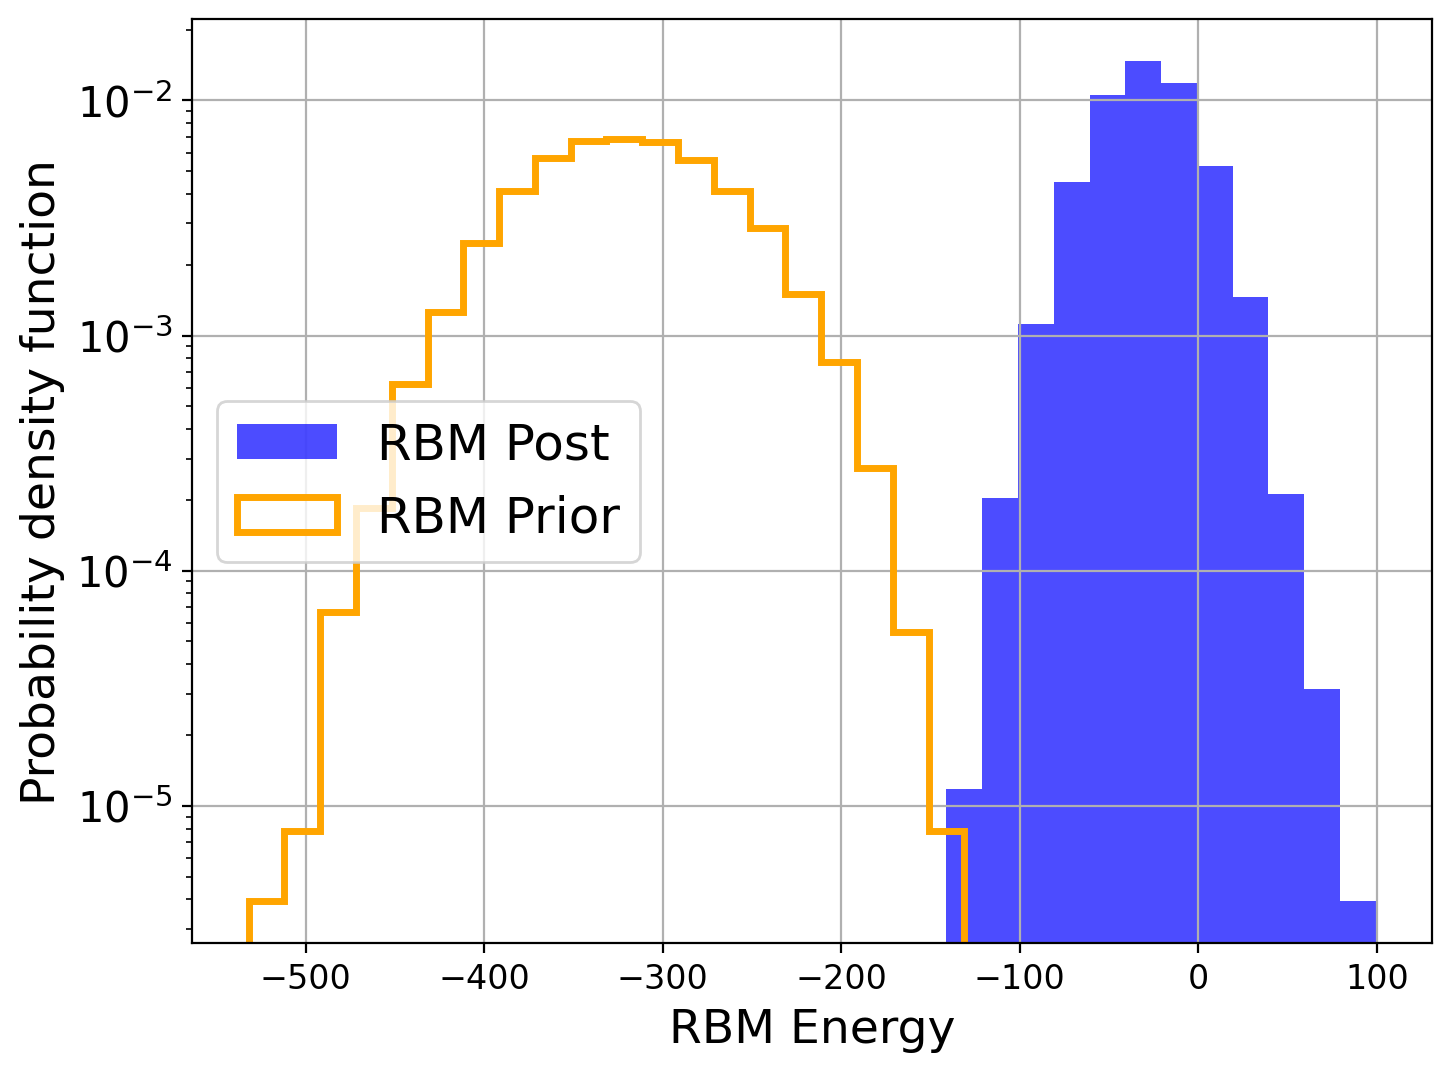

In [4]:
self.evaluate(self.data_mgr.test_loader, 0)

In [12]:
self.fit(0)

/usr/local/lib/python3.12/dist-packages/torch/_tensor.py:1128: UserWarning:

Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/Scalar.cpp:22.)

[21:44:38.315] INFO   engine.engine                                     Epoch: 0 [0/796 (0%)]	 beta: 1.000, slope: 0.050 	 Batch Loss: 41711.0547
[21:55:59.832] INFO   engine.engine                                     Epoch: 0 [79/796 (10%)]	 beta: 1.000, slope: 0.050 	 Batch Loss: 3001.2837


KeyboardInterrupt: 